<a href="https://colab.research.google.com/github/Zapak23/NBA_salary_predictions/blob/main/NBA_Salary_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Salary Prediction Notebook

This dataset was found on Kaggle. It contains data on NBA players and their salary in millions of dollars.
In this Notebook, I will cover

*   Reading the data
*   Exploratory data analysis
*   Model building
*   Final Notes







## Reading the data

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_players = pd.read_csv("nba_2017_players_with_salary_wiki_twitter.csv", index_col=0)
df_players.head()

,Rk,PLAYER,POSITION,AGE,MP,FG,FGA,FG%,3P,3PA,...,DRPM,RPM,WINS_RPM,PIE,PACE,W,SALARY_MILLIONS,PAGEVIEWS,TWITTER_FAVORITE_COUNT,TWITTER_RETWEET_COUNT
0,1,Russell Westbrook,PG,28,34.6,10.2,24.0,0.425,2.5,7.2,...,-0.47,6.27,17.34,23.0,102.31,46,26.50,4279.0,2130.5,559.0
1,2,James Harden,PG,27,36.4,8.3,18.9,0.440,3.2,9.3,...,-1.57,4.81,15.54,19.0,102.98,54,26.50,3279.0,969.0,321.5
2,4,Anthony Davis,C,23,36.1,10.3,20.3,0.505,0.5,1.8,...,3.90,4.35,12.81,19.2,100.19,31,22.12,82.5,368.0,104.0
3,6,DeMarcus Cousins,C,26,34.2,9.0,19.9,0.452,1.8,5.0,...,0.64,4.20,11.26,17.8,97.11,30,16.96,1625.5,102.0,91.5
4,7,Damian Lillard,PG,26,35.9,8.8,19.8,0.444,2.9,7.7,...,-1.49,3.14,10.72,15.9,99.68,38,24.33,1830.5,186.5,43.0


In [ ]:
df_players.info()

# We have a few missing values, lets replace them with the mean
avg_favorite_count = df_players['TWITTER_FAVORITE_COUNT'].mean()
avg_retweet_count = df_players['TWITTER_RETWEET_COUNT'].mean()

df_players['TWITTER_FAVORITE_COUNT'] = df_players['TWITTER_FAVORITE_COUNT'].fillna(avg_favorite_count, inplace=True)
df_players['TWITTER_RETWEET_COUNT'] = df_players['TWITTER_RETWEET_COUNT'].fillna(avg_retweet_count, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 238
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rk                      239 non-null    int64  
 1   PLAYER                  239 non-null    object 
 2   POSITION                239 non-null    object 
 3   AGE                     239 non-null    int64  
 4   MP                      239 non-null    float64
 5   FG                      239 non-null    float64
 6   FGA                     239 non-null    float64
 7   FG%                     239 non-null    float64
 8   3P                      239 non-null    float64
 9   3PA                     239 non-null    float64
 10  3P%                     232 non-null    float64
 11  2P                      239 non-null    float64
 12  2PA                     239 non-null    float64
 13  2P%                     239 non-null    float64
 14  eFG%                    239 non-null    fl

##Exploratory Data Analysis

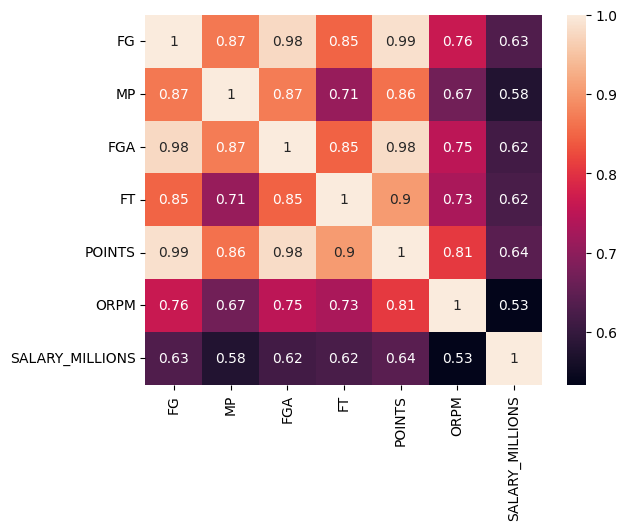

In [ ]:
#Picked columns of interest and created a heatmap

columns_to_keep = ['FG', 'MP', 'FGA', 'FT', 'POINTS', 'ORPM', 'SALARY_MILLIONS']
df_heat = df_players[columns_to_keep]

sns.heatmap(df_heat.corr(), annot= True)

plt.rcParams['figure.figsize'] = (20, 8)

plt.show()

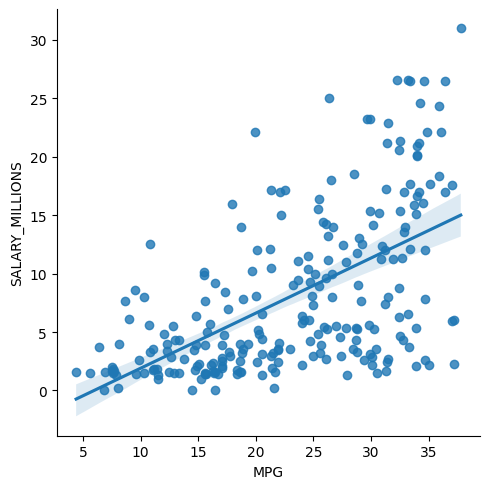

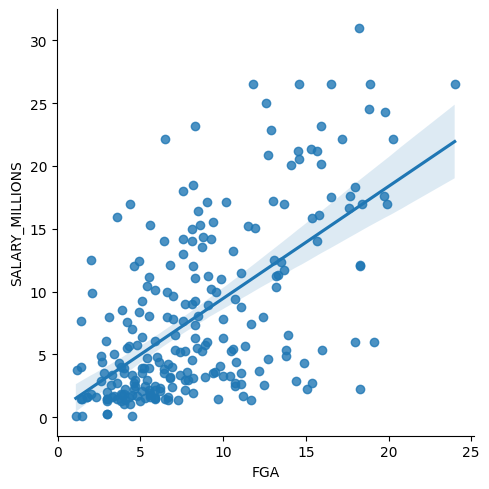

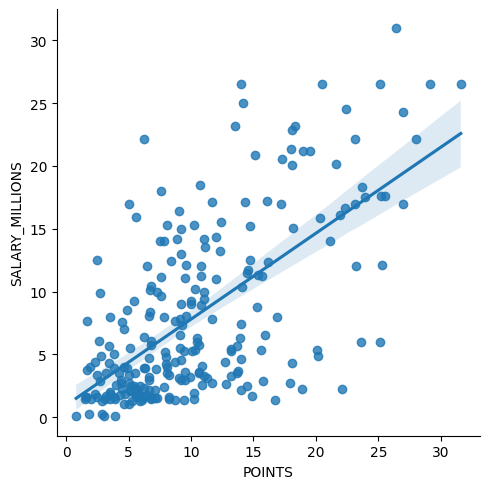

In [ ]:
# Plotting linear models for variables
sns.lmplot(x="MPG", y="SALARY_MILLIONS", data=df_players)
plt.show()

sns.lmplot(x="FGA", y="SALARY_MILLIONS", data=df_players)
plt.show()

sns.lmplot(x="POINTS", y="SALARY_MILLIONS", data=df_players)
plt.show()

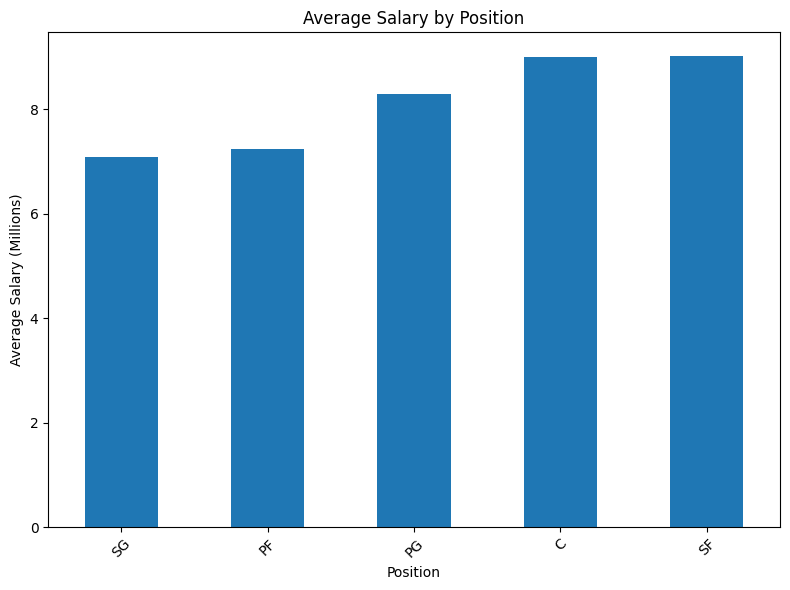

In [ ]:
# Group the data by POSITION and calculate the average salary for each position
position_salary_avg = df_players.groupby('POSITION')['SALARY_MILLIONS'].mean().sort_values()

# Create a bar chart
plt.figure(figsize=(8, 6))  # Set the figure size
position_salary_avg.plot(kind='bar')

# Add labels and title
plt.xlabel('Position')
plt.ylabel('Average Salary (Millions)')
plt.title('Average Salary by Position')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing
plt.show()



## Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Encode Categorical Position
df_players.info()
# Use pandas' get_dummies function to perform one-hot encoding
one_hot_encoded = pd.get_dummies(df_players['POSITION'], prefix='POSITION')

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_players_pos = pd.concat([df_players, one_hot_encoded], axis=1)

# Drop the original categorical column
df_players_pos = df_players_pos.drop('POSITION', axis=1)

df_players_pos.info()

In [ ]:
X = df_players_pos[['PAGEVIEWS', 'MPG',
                'POINTS', 'DRPM', 'ORPM', 'AGE', 'POSITION_C', 'POSITION_PF', 'POSITION_SF',
                    'POSITION_SG', 'POSITION_PG']]
y = df_players_pos['SALARY_MILLIONS']

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [ ]:
#XG Boost Model

# Define the model

my_model_1 = XGBRegressor(n_estimators = 1000, learning_rate = .05)

# Fit the model
my_model_1.fit(X_train, y_train)

# Get predictions
predictions_1 = my_model_1.predict(X_valid)

# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)

print("Mean Absolute Error:" , mae_1)

Mean Absolute Error: 3.7409468345840775


##Final Notes

Within this notebook, I looked over data regarding NBA player stats with the goal of creating a machine learning model that could predict the salary of an NBA player given his stats and other information. By the end, my model was able to predict salaries with a mean absolute error of 3.74 million dollars. While this is a lot of money, this is a great place to start, and I hope to improve this model in the future!